SETUP

In [2]:
#SETUP
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [3]:
#imports
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
import librosa

import pickle
from keras.callbacks import ModelCheckpoint
#from cfg import Config


In [4]:
class Config:
    def __init__(self, mode='conv', nfilt=60, nfeat=13, nfft=1024, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.rate = rate
        self.nfft = nfft
        self.step = int(rate/2)
        self.model_path = os.path.join('models', mode + '.model')
        self.p_path = os.path.join('pickles', mode + '.p')

config = Config(mode='conv')

CREATE DATAFRAME

In [5]:
#DEFINE CONFIG IN NOTEBOOK
#DOES NOT UPDATES!!
def create_df(dir):
    df_output = pd.DataFrame(columns=['path','tram_label','filename', 'length'])
    i=0
    for folder in os.listdir(dir):
        if not folder.startswith('.'):
            for subfolder in os.listdir(data_dir+"/"+folder):
                if not subfolder.startswith('.'):
                    for filename in tqdm(os.listdir(data_dir+"/"+folder+'/'+subfolder)):
                        if not filename.startswith('.'):
                            #print(i)
                            #print(data_dir+"/"+folder+'/'+subfolder+'/'+filename)
                            rate, signal = wavfile.read(data_dir+"/"+folder+'/'+subfolder+'/'+filename)
                            #print(rate);
                            df_output.loc[i] = [data_dir+"/"+folder+'/'+subfolder+'/'+filename,
                                         folder+'/'+subfolder,
                                         filename,
                                         signal.shape[0]/rate]
                            i+=1
    return df_output

data_dir = os.path.expanduser('tram_demo/downsampled')
df = create_df(data_dir)
df.set_index('filename', inplace=True)

100%|██████████| 828/828 [00:10<00:00, 75.55it/s]


In [7]:
df.head()

,path,tram_label,length
filename,,,
tram-2018-11-24-21-18-54_40.70_43.73.mp4.wav,tram_demo/downsampled/braking/3_CKD_Short/tram...,braking/3_CKD_Short,3.030000
tram-2018-11-19-11-23-43_245.67_251.40.mp4.wav,tram_demo/downsampled/braking/3_CKD_Short/tram...,braking/3_CKD_Short,5.730062
tram-2018-11-23-22-20-22_4.30_8.63.mp4.wav,tram_demo/downsampled/braking/3_CKD_Short/tram...,braking/3_CKD_Short,4.330000
tram-2018-11-27-01-51-38_154.80_157.30.mp4.wav,tram_demo/downsampled/braking/3_CKD_Short/tram...,braking/3_CKD_Short,2.500000
tram-2018-11-26-15-22-20_72.30_76.53.mp4.wav,tram_demo/downsampled/braking/3_CKD_Short/tram...,braking/3_CKD_Short,4.230000


FEATURE EXTRACTION

In [6]:
classes = list(np.unique(df['tram_label']))
class_dist = df.groupby(['tram_label'])['length'].mean()
n_samples = 5*int(df['length'].sum() / 0.1) #number of samples for features matrix
prob_dist = class_dist / class_dist.sum() #probability distribution

In [7]:
#FUNCTIONS

#build feature matrix
# def windows(data, window_size):
#     start = 0
#     while start < len(data):
#         yield start, start + window_size
#         start += (window_size / 2)
def build_rand_feat(part_start, part_end):
    X = []
    y = []
    _min, _max = float('inf'), -float('inf') #set like this in order to be updated
    for fn in tqdm(df['path'][part_start : part_end]):
        #rand_class = np.random.choice(class_dist.index, p=prob_dist)
        #file = np.random.choice(df[df.label==rand_class].index)
        #label = df.at[file, 'label']
        rate, wav = wavfile.read(fn)
        label = df[df.path == fn].tram_label[0]
        
        for i in np.arange(0, len(wav), config.step/20): #/22
        #range(0, len(wav), config.step):
            start = int(i)
            end = int(i+config.step) if (i+config.step <= len(wav)) else len(wav)
            if(len(wav[start:end]) == config.step):
                sample = wav[start:end]
                X_sample = mfcc(sample, rate,
                            numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft) #just regular fcc
                _min = min(np.amin(X_sample), _min)
                _max = max(np.amax(X_sample), _max)
                X.append(X_sample)
                y.append(classes.index(label)) #encoding classes to integers
        
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) #adding greyscale pixel
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes = 9) #should we remove 1 in order to avoid a cat val trap?
#     config.data = (X, y)
    
#     with open(config.p_path, 'wb') as handle:
#         pickle.dump(config, handle, protocol=2)
    return X, y


In [8]:
X, y = build_rand_feat(0, 500)
X_part, y_part = build_rand_feat(500, 1000)
X_part1, y_part1 = build_rand_feat(1000, 1500)
X_part2, y_part2 = build_rand_feat(1500, 2000)
X_part3, y_part3 = build_rand_feat(2000, 2500)
X_part4, y_part4 = build_rand_feat(2500, 2997)
    

100%|██████████| 496/496 [05:21<00:00,  1.51it/s]


In [11]:
X_append = np.concatenate((X, X_part,X_part1,X_part2,X_part3,X_part4), axis=0)
y_append = np.concatenate((y, y_part,y_part1,y_part2,y_part3,y_part4), axis=0)


In [1]:
print(X_append.shape, y_append.shape)

NameError: name 'X_append' is not defined

In [23]:
#TRY TO SAVE EXTRACTED FEATURES TO CSV - ONLY FOR 2D
# pd.DataFrame(X_append).to_csv("extracted_feat/X_extract.csv")
# pd.DataFrame(y_append).to_csv("extracted_feat/y_extract.csv")

ValueError: Must pass 2-d input

In [ ]:
#THIS CAUSES ERROR - probably to big size for saving
config.data = (X_append, y_append)
    
with open(config.p_path, 'wb') as handle:
    pickle.dump(config, handle, protocol=2)

In [11]:
X.shape

(32095, 49, 13, 1)

In [17]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (7,7), activation='relu', strides=(1,1),
                     padding='same', input_shape=input_shape)) #pulling only once because matrix size (13,9,1) - in order to preserve data
    model.add(Conv2D(32, (7,7), activation='relu', strides=(1,1),
                     padding='same'))
    model.add(MaxPool2D((4,4)))
    model.add(Conv2D(32, (5,5), activation='relu', strides=(1,1),
                     padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                     padding='same'))
    model.add(MaxPool2D((2,5)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
def loda_features():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp.data[0], tmp.data[1]
    else:
        return None


In [18]:
#X, y = load_features()
X, y = X_append, y_append
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model = get_conv_model()
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                         save_best_only=True, save_weights_only=False, period=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 49, 13, 16)        160       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 49, 13, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 49, 13, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 13, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 49, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 6, 128)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 6, 128)        0         
__________

In [19]:
model = get_conv_model()
history = model.fit(X, y, epochs=10, batch_size=32,
          shuffle=True,
          validation_split=0.1,
          callbacks=[checkpoint])
model.save(config.model_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 49, 13, 16)        160       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 49, 13, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 49, 13, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 49, 13, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 49, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 6, 128)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 6, 128)        0         
__________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



543855/543855 [==============================] - 1427s 3ms/step - loss: 0.0823 - acc: 0.9724 - val_loss: 0.1636 - val_acc: 0.9608

Epoch 00009: val_acc did not improve from 0.97806
Epoch 10/10
 10592/543855 [..............................] - ETA: 22:51 - loss: 0.0776 - acc: 0.9748

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



462016/543855 [========================>.....] - ETA: 3:32 - loss: 0.0793 - acc: 0.9736

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
from keras.models import load_model
model = load_model('models/conv.model')
history.history

W0703 21:09:01.393248 140474100987712 deprecation_wrapper.py:119] From /data/users/mscibor/trams.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 21:09:01.395145 140474100987712 deprecation_wrapper.py:119] From /data/users/mscibor/trams.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 21:09:01.431750 140474100987712 deprecation_wrapper.py:119] From /data/users/mscibor/trams.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 21:09:01.432249 140474100987712 deprecation_wrapper.py:119] From /data/users/mscibor/trams.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Plea

NameError: name 'history' is not defined

<module 'matplotlib.pyplot' from '/data/users/mscibor/trams.env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

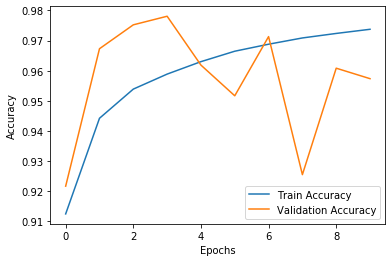

In [22]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt

In [9]:

config.max

68.85964767524779

In [10]:
 config.min

-83.47210746139987